# Testing ICA-AROMA regression
The [current fmriprep pipeline](https://github.com/poldracklab/fmriprep/tree/1.1.1) extracts confounds (csf, white matter, global signal, etc) from the non-denoised bold series, whereas in [Pruim et al. (2015)](https://www.sciencedirect.com/science/article/pii/S1053811915001822?via%3Dihub), ICA-AROMA is applied after spatial smoothing, but before any additional nuisance regression. Directly from the paper, the authors say:
> Within the typical fMRI participant-level preprocessing stream ICA-AROMA is applied after spatial smoothing but prior to high-pass filtering and further nuisance regression

However, it is unknown whether choosing the nuisance regressors before or after denoising with ICA-AROMA has a detriment on outcome measures.

The first test will mirror [Hallquist's The Nuisance of Nuisance Regression](https://www.ncbi.nlm.nih.gov/pubmed/23747457) where I will replicate the simulation signal they used and test the impact of an additional nuisance (I'll call it csf) when it is cleaned (e.g. derived from the denoised bold series) or unclean (derived from the raw bold series)

* Please see the [pull request](https://github.com/poldracklab/fmriprep/pull/959), [issue 817](https://github.com/poldracklab/fmriprep/issues/817), and [issue 1049](https://github.com/poldracklab/fmriprep/issues/1049) associated with this topic for more information.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 5]
import seaborn as sns
from scipy.signal import periodogram

In [53]:
# number of timepoints
tp = 200
# create array that contains 200 elements
ix = np.arange(tp)
 
# 0.2 hz
signal1 = np.sin(2*np.pi*ix*(4/tp))
# 0.035 hz
signal2 = np.sin(2*np.pi*ix*(7/tp))
# .11 hz (to be pulled out by ica-aroma)
motion1 = np.cos(2*np.pi*ix*(22/tp))
# .25 hz (to be pulled out by ica-aroma)
motion2 = np.cos(2*np.pi*ix*(50/tp))

# create totals for the signals and the noise
signal_total = signal1 + signal2
motion_total = motion1 + motion2

# make the csf signal share variance with one of the noise components
csf = (np.cos(2*np.pi*ix*(60/tp)) + motion1) / 2

# the simulated bold timecourse
bold = signal_total + motion_total + csf

Text(0.5,0,'Time (Seconds)')

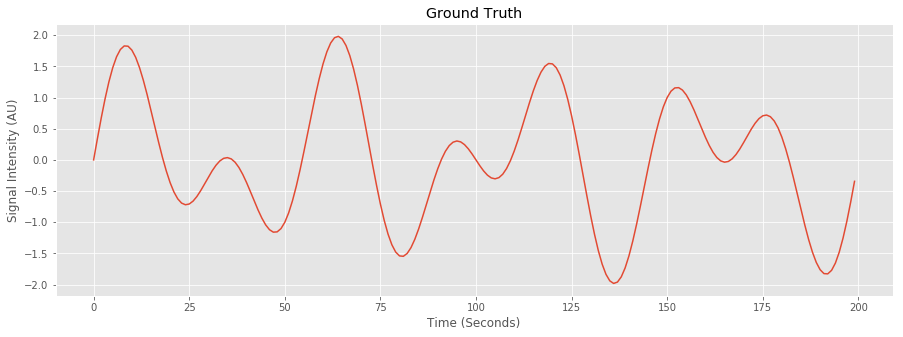

In [54]:
plt.plot(signal_total)
plt.title('Ground Truth')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

Text(0.5,0,'Time (Seconds)')

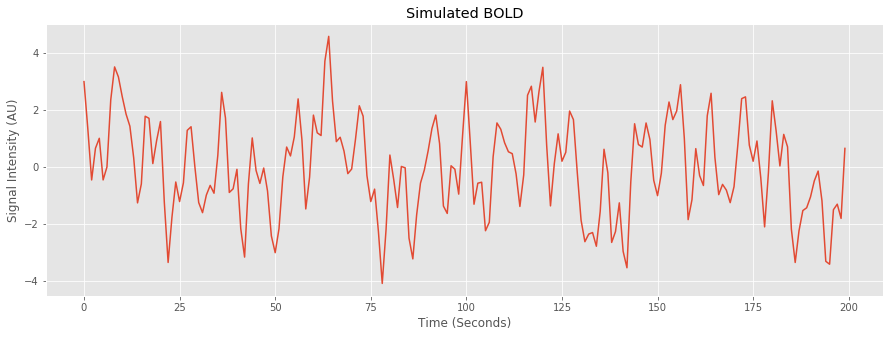

In [55]:
plt.plot(bold)
plt.title('Simulated BOLD')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

In [56]:
# non-aggresive denoising

# Create a Melodic design matrix, where we model the intercept, the two signal components
# and the two noise components
design = np.ones((tp, 5))
design[:, 1] = signal1
design[:, 2] = signal2
design[:, 3] = motion1
design[:, 4] = motion2


unmixMatrix = np.linalg.pinv(design)
maps = np.dot(unmixMatrix, bold)

# only select the noise maps
noisemap = maps[3:]

# calculate the residual
nonagg_residual = np.dot(np.stack((motion1, motion2), axis=1), noisemap)

# denoise the bold
bold_denoised = bold - nonagg_residual

Text(0.5,0,'Time (Seconds)')

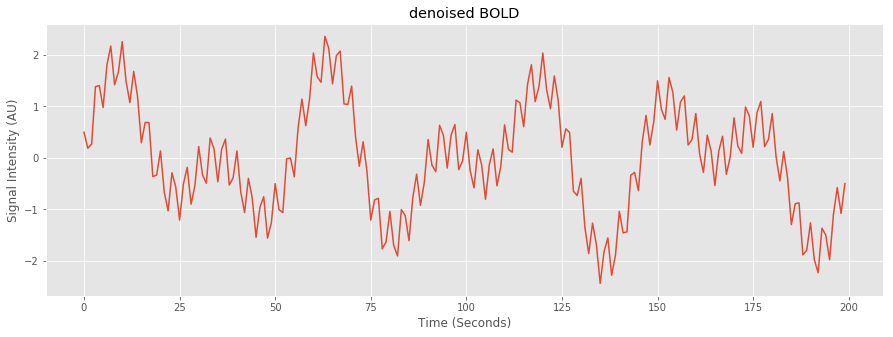

In [57]:
plt.plot(bold_denoised)
plt.title('denoised BOLD')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

In [58]:
# apply the same regression to the csf component
# same as extracting csf after nonaggressive denoising
csf_clean = csf - nonagg_residual

# make design matrices for "cleaned" csf and non-cleaned csf
csf_clean_design = np.stack((np.ones(tp), csf_clean), axis=1)

csf_clean_residual = np.dot(csf_clean_design, np.dot(np.linalg.pinv(csf_clean_design), bold_denoised))
# remove the csf clean residual
bold_denoised_nuisance = bold_denoised - csf_clean_residual

Text(0.5,0,'Time (Seconds)')

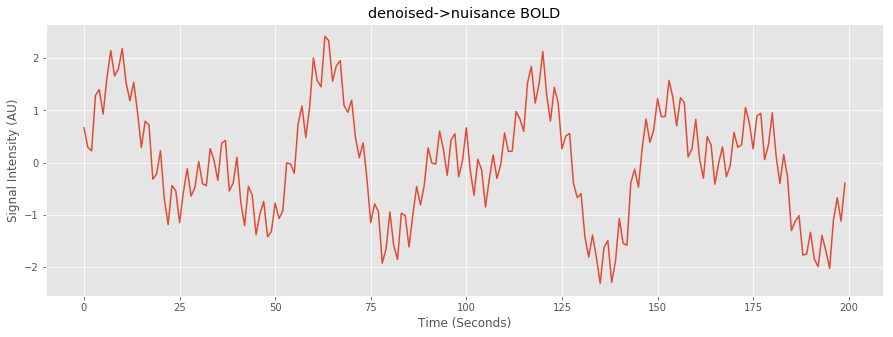

In [59]:
plt.plot(bold_denoised_nuisance)
plt.title('denoised->nuisance BOLD')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

In [60]:
# raw csf design
csf_raw_design = np.stack((np.ones(tp), csf), axis=1)

csf_residual = np.dot(csf_raw_design, np.dot(np.linalg.pinv(csf_raw_design), bold_denoised))

# remove the csf_tot uncleaned residual
bold_nuisance_denoised = bold_denoised - csf_residual

Text(0.5,0,'Time (Seconds)')

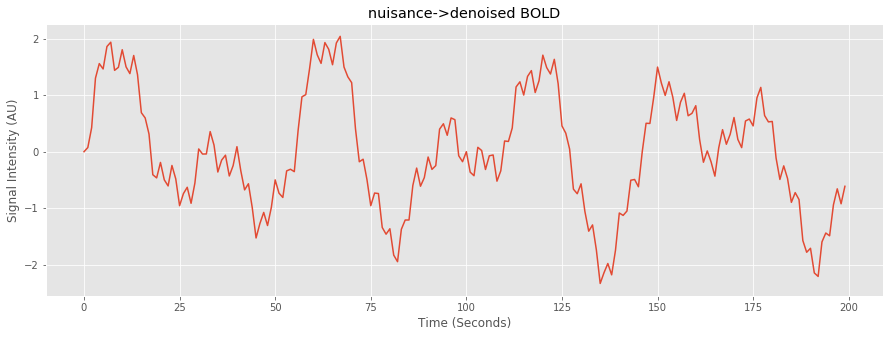

In [61]:
plt.plot(bold_nuisance_denoised)
plt.title('nuisance->denoised BOLD')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Seconds)')

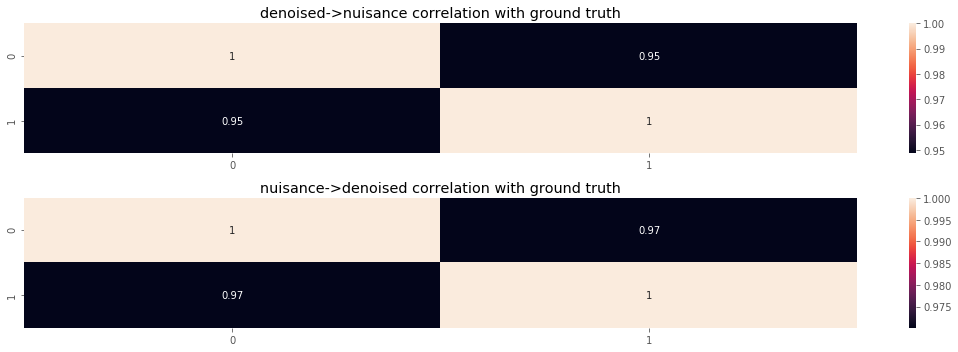

In [62]:
# compare correlations
denoised_nuisance_ground_truth_correlation = np.corrcoef(signal_total, bold_denoised_nuisance)
nuisance_denoised_ground_truth_correlation = np.corrcoef(signal_total, bold_nuisance_denoised)
plt.figure(1)

plt.subplot(211)
sns.heatmap(denoised_nuisance_ground_truth_correlation, annot=True)
plt.title('denoised->nuisance correlation with ground truth')

plt.subplot(212)
sns.heatmap(nuisance_denoised_ground_truth_correlation, annot=True)
plt.title('nuisance->denoised correlation with ground truth')

plt.tight_layout()

Text(0,0.5,'Frequency Power')

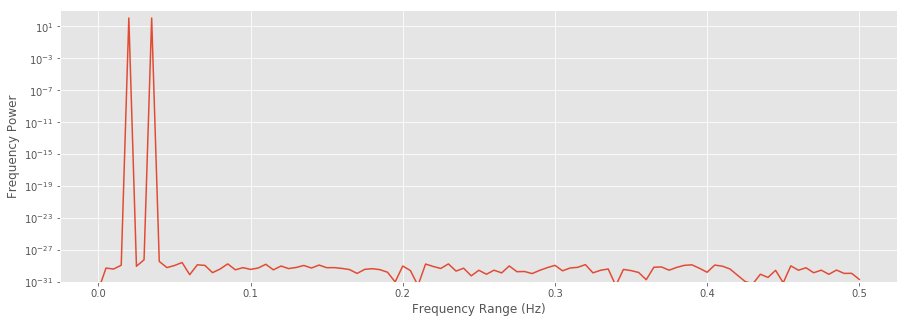

In [63]:
# compare periodograms
frequencies, ground_truth_density = periodogram(signal_total)
plt.semilogy(frequencies, ground_truth_density)
plt.ylim([1e-31, 1e3])
plt.xlabel('Frequency Range (Hz)')
plt.ylabel('Frequency Power')

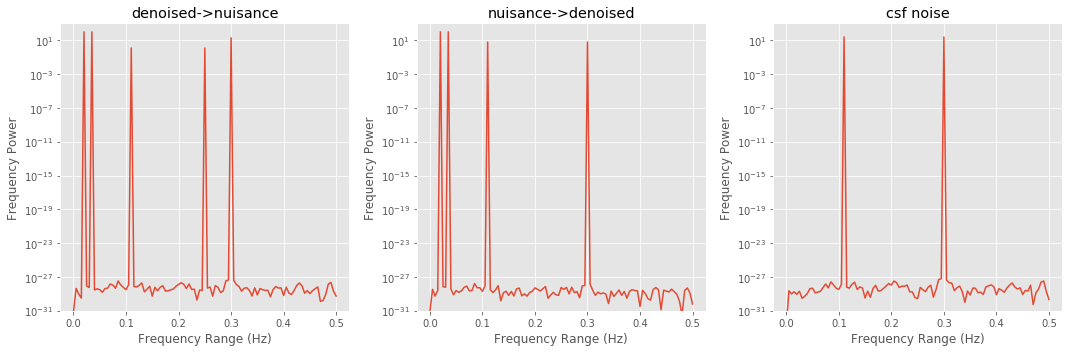

In [65]:
frequencies, denoised_nuisance_density = periodogram(bold_denoised_nuisance)
frequencies, nuisance_denoised_density = periodogram(bold_nuisance_denoised)
frequencies, csf_density = periodogram(csf)
plt.figure(1)

plt.subplot(131)
plt.semilogy(frequencies, denoised_nuisance_density)
plt.ylim([1e-31, 1e3])
plt.title('denoised->nuisance')
plt.xlabel('Frequency Range (Hz)')
plt.ylabel('Frequency Power')

plt.subplot(132)
plt.semilogy(frequencies, nuisance_denoised_density)
plt.ylim([1e-31, 1e3])
plt.title('nuisance->denoised')
plt.xlabel('Frequency Range (Hz)')
plt.ylabel('Frequency Power')

plt.subplot(133)
plt.semilogy(frequencies, csf_density)
plt.ylim([1e-31, 1e3])
plt.title('csf noise')
plt.xlabel('Frequency Range (Hz)')
plt.ylabel('Frequency Power')

plt.tight_layout()

## Hallquist Conclusion
The correlations show a slightly stronger relationship between the nuisance->denoised bold as opposed to the denoised->nuisance bold.
It also appears extracting the nuisance regressor and then denoising (the middle graph) suppresses one of the csf peaks, whereas denoising and then extracting the csf nuisance (left graph) does not suppress the peak.



## Repeated Simulation

I will now perform many iterations of the above example with random numbers for each component as opposed to defined frequency components

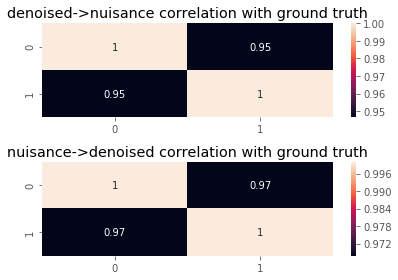

In [8]:
np.random.seed(123)
denoised_nuisance_collector = []
nuisance_denoised_collector = []
for _ in range(1000):
    random_signal1 = np.random.rand(200)
    random_signal2 = np.random.rand(200)
    
    random_motion1 = np.random.rand(200)
    random_motion2 = np.random.rand(200)
    
    random_csf = (np.random.rand(200) + random_motion1) / 2
    
    
    random_bold = random_signal1 + random_signal2 + random_motion1 + random_motion2 + random_csf
    
    # non-aggresive denoising
    Rdesign = np.ones((200, 5))
    Rdesign[:, 1] = random_signal1
    Rdesign[:, 2] = random_signal2
    Rdesign[:, 3] = random_motion1
    Rdesign[:, 4] = random_motion2

    RunmixMatrix = np.linalg.pinv(Rdesign)
    Rmaps = np.dot(RunmixMatrix, random_bold)

    Rnoisemap = Rmaps[3:]

    Rnonagg_residual = np.dot(np.stack((random_motion1, random_motion2), axis=1), Rnoisemap)
    random_bold_denoised = random_bold - Rnonagg_residual
    
    # apply the same regression to the csf component
    # same as extracting csf after nonaggressive denoising
    random_csf_clean = random_csf - Rnonagg_residual

    # make design matrices for denoised csf and non-denoised csf
    Rcsf_clean_design = np.stack((np.ones(200), random_csf_clean), axis=1)

    Rcsf_design = np.stack((np.ones(200), random_csf), axis=1)
    
    Rcsf_clean_residual = np.dot(Rcsf_clean_design, 
                                 np.dot(np.linalg.pinv(Rcsf_clean_design), random_bold_denoised))
    
    # remove the denoised csf residual
    random_bold_denoised_nuisance = random_bold_denoised - Rcsf_clean_residual

    Rcsf_residual = np.dot(Rcsf_design, 
                           np.dot(np.linalg.pinv(Rcsf_design), random_bold_denoised))
    
    # remove the raw csf residual
    random_bold_nuisance_denoised = random_bold_denoised - Rcsf_residual
    
    signal_total = random_signal1 + random_signal2
    
    denoised_nuisance_collector.append(np.corrcoef(signal_total, random_bold_denoised_nuisance))
    
    nuisance_denoised_collector.append(np.corrcoef(signal_total, random_bold_nuisance_denoised))
    
mean_denoised_nuisance_correlation = np.mean(np.array(denoised_nuisance_collector), axis=0)
mean_nuisance_denoised_correlation = np.mean(np.array(nuisance_denoised_collector), axis=0)

plt.figure(1)

plt.subplot(211)
sns.heatmap(mean_denoised_nuisance_correlation, annot=True)
plt.title('denoised->nuisance correlation with ground truth')

plt.subplot(212)
sns.heatmap(mean_nuisance_denoised_correlation, annot=True)
plt.title('nuisance->denoised correlation with ground truth')

plt.tight_layout()

## Conclusion

The simulation suggests a slight benefit towards extracting the nuisance regressor before denoising as opposed to extracting the nuisance regressor after denoising.

### Assumptions 
1. The nuisance csf is correlated with the noise components (e.g. csf signal is related to motion). When csf noise is generated independently, the nuisance->denoised order perfectly reconstructs the signal

2. I didn't model autocorrelation (would that be relevant in this context?)

3. ???